# Временные ряды 4.  Построение и оценка модели

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, $\dots$ от 90 до 100-й точках.

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../Lesson_2/my_PJME_MW.csv', index_col=[0], parse_dates=[0])
TARGET = 'PJME_MW'

In [3]:
def week_resample(data):
    data_w = data.resample('W').mean()
    data_w.drop(['dayofmonth', 'dayofyear', 'dayofweek', 'hour', 
                 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1, inplace=True)
    return data_w

In [4]:
data_w = week_resample(data)
data_w.tail()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2018-07-08,38459.982143,2018.0,7.000000,3.0,27.0
2018-07-15,36420.035714,2018.0,7.000000,3.0,28.0
2018-07-22,35612.095238,2018.0,7.000000,3.0,29.0
2018-07-29,36581.821429,2018.0,7.000000,3.0,30.0
2018-08-05,36568.804124,2018.0,7.505155,3.0,31.0


#### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков

Добавялем истории до 52-й недели включительно. 52 берем, используя результаты автокорреляционного анализа из предшествующих уроков

In [5]:
def add_history_features(data, p):
    for i in range(p):
        data['t' + str(p - i)] = 0
        data['t' + str(p - i)].values[p:] = data[TARGET].values[i:-p + i]

In [6]:
h = 4
p = 52
add_history_features(data_w, p)

Добавляем первые разности

In [7]:
first_diff = np.array(data_w.iloc[1:, 0].values - data_w.iloc[:-1, 0].values).astype('float32')
data_w['diff1'] = 0
data_w['diff1'] = data_w['diff1'].astype('float')
data_w['diff1'].values[1:] = first_diff

k = 13
for i in range(k):
    data_w['d' + str(k - i)] = 0
    data_w['d' + str(k - i)].values[k:] = data_w['diff1'].values[i:-k + i]

Экспоненциальное сглаживание

In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [9]:
for i in range(1, 10):
    data_w['exp_0_0' + str(i)] = exponential_smoothing(data_w[TARGET], i * 0.01)

Формируем список целевой переменной и тренировочных данных.
Значения целевой переменной будут сдвинуты на р=4 дня. Так как предсказываем на 4 дня вперед.

In [10]:
scl_target4 = StandardScaler()

target = data_w[TARGET].values[h + p:].reshape((data_w.shape[0] - h - p, 1))
y = scl_target4.fit_transform(target)
y.shape

(810, 1)

In [11]:
scl_x4 = StandardScaler()

X = data_w.iloc[p:-h].values

X = scl_x4.fit_transform(X.astype('float64'))
X.shape

(810, 80)

Отбор признаков

In [12]:
f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)

sfk = SelectKBest(f_regression, k=5)
X_new1 = sfk.fit_transform(X, y.ravel())
X_new1.shape

(810, 5)

In [13]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['t50', 't49', 't48', 't47', 't46'], dtype='object')

In [14]:
sfp = SelectPercentile(f_regression, percentile = 10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(810, 8)

In [15]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['t50', 't49', 't48', 't47', 't46', 't35', 't34', 't9'], dtype='object')

In [16]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=500).fit(X, y.ravel())
sfm = SelectFromModel(gr_model, max_features=5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(810, 5)

In [17]:
list_param_k = list(np.where(sfk.get_support())[0])
list_param_p = list(np.where(sfp.get_support())[0])
list_param_m = list(np.where(sfm.get_support())[0])

print('Номера k лучших признаков: ', list_param_k)
print('Номера признаков лучших признаков по процентной форме: ', list_param_p)
print('Номера признаков для выбора по модели: ', list_param_m)

Номера k лучших признаков:  [7, 8, 9, 10, 11]
Номера признаков лучших признаков по процентной форме:  [7, 8, 9, 10, 11, 22, 23, 48]
Номера признаков для выбора по модели:  [8, 9, 23, 34, 35]


In [18]:
list_param = list(set(sum([list_param_k, list_param_p, list_param_m], [])))
list_param

[34, 35, 7, 8, 9, 10, 11, 48, 22, 23]

In [19]:
X_new = X[:, list_param]
data_w.columns[list_param]

Index(['t23', 't22', 't50', 't49', 't48', 't47', 't46', 't9', 't35', 't34'], dtype='object')

#### Количество примеров в тестовом наборе

In [20]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') > split_date].copy()

In [21]:
train, test = split_data(data_w, '01-06-2016')

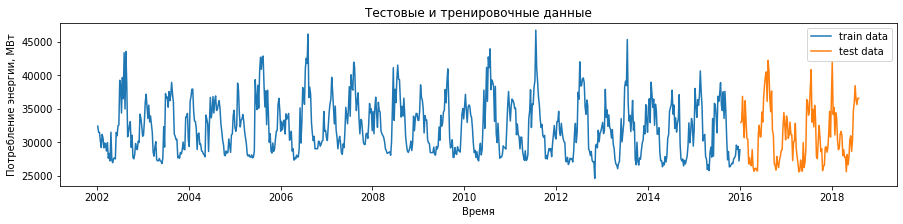

In [22]:
plt.figure(figsize=(15, 3))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'), train[TARGET], label='train data')
plt.plot(test.index.get_level_values('Date'), test[TARGET], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

#### Обучаем модель

In [23]:
X_train = X_new[:-test.shape[0], :]
y_train = y[:-test.shape[0], 0]

X_test4 = X_new[-test.shape[0]:, : ]
y_test4 = y[-test.shape[0]:, 0]

In [24]:
model_g = GradientBoostingRegressor(max_depth=3, random_state=40, n_estimators=100)
model_l = LinearRegression()

In [25]:
model_g.fit(X_train, y_train)
model_l.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
y_test_pred4_g = model_g.predict(X_test4)
y_test_pred4_l = model_l.predict(X_test4)

In [27]:
y_test_pred4_l.shape

(135,)

In [28]:
test.shape

(135, 80)

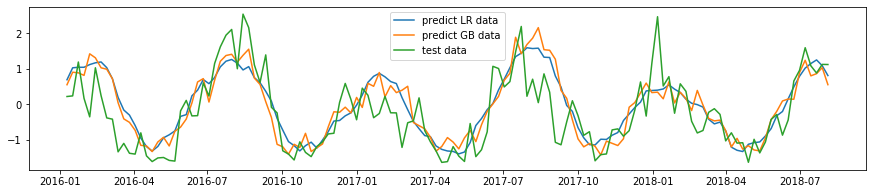

In [29]:
plt.figure(figsize=(15, 3))

plt.xlabel('')
plt.ylabel('')
plt.plot(test.index.get_level_values('Date'), y_test_pred4_l, label='predict LR data')
plt.plot(test.index.get_level_values('Date'), y_test_pred4_g, label='predict GB data')
plt.plot(test.index.get_level_values('Date'), y_test4, label='test data')

plt.legend()
plt.show()

In [30]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
er_l = MAPE(scl_target4.inverse_transform(y_test4), 
                                      scl_target4.inverse_transform(y_test_pred4_l))
print(f'MAPE модели линейной регрессии: {er_l}%')
er_g = MAPE(scl_target4.inverse_transform(y_test4), 
                                      scl_target4.inverse_transform(y_test_pred4_g))
print(f'MAPE модели градиентного бустинга: {er_g}%')

MAPE модели линейной регрессии: 6.790029814505935%
MAPE модели градиентного бустинга: 6.928952488973761%


#### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков

Данную модель будем использованть далее для авторекурсии. Для неё заново считаем новые признаки

In [32]:
data_w = week_resample(data)

In [33]:
h = 1
add_history_features(data_w, p)

In [34]:
first_diff = np.array(data_w.iloc[1:, 0].values - data_w.iloc[:-1, 0].values).astype('float32')
data_w['diff1'] = 0
data_w['diff1'] = data_w['diff1'].astype('float')
data_w['diff1'].values[1:] = first_diff

k = 13
for i in range(k):
    data_w['d' + str(k - i)] = 0
    data_w['d' + str(k - i)].values[k:] = data_w['diff1'].values[i:-k + i]

In [35]:
for i in range(1, 10):
    data_w['exp_0_0' + str(i)] = exponential_smoothing(data_w[TARGET], i * 0.01)

In [36]:
scl_target = StandardScaler()

target = data_w[TARGET].values[h + p:].reshape((data_w.shape[0] - h - p, 1))
y = scl_target.fit_transform(target)
y.shape

(813, 1)

In [37]:
scl_x = StandardScaler()

X = data_w.iloc[p:-h, :].values

X = scl_x.fit_transform(X.astype('float64'))
X.shape

(813, 80)

In [38]:
f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)

sfk = SelectKBest(f_regression, k=5)
X_new1 = sfk.fit_transform(X, y.ravel())
X_new1.shape

(813, 5)

In [39]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 't52', 't51', 't50', 't1'], dtype='object')

In [40]:
sfp = SelectPercentile(f_regression, percentile = 10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(813, 8)

In [41]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 't52', 't51', 't50', 't49', 't38', 't37', 't1'], dtype='object')

In [42]:
gr_model = GradientBoostingRegressor(max_depth=5, n_estimators=500).fit(X, y.ravel())
sfm = SelectFromModel(gr_model, max_features=5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(813, 5)

In [43]:
list_param_k = list(np.where(sfk.get_support())[0])
list_param_p = list(np.where(sfp.get_support())[0])
list_param_m = list(np.where(sfm.get_support())[0])

print('Номера k лучших признаков: ', list_param_k)
print('Номера признаков лучших признаков по процентной форме: ', list_param_p)
print('Номера признаков для выбора по модели: ', list_param_m)

Номера k лучших признаков:  [0, 5, 6, 7, 56]
Номера признаков лучших признаков по процентной форме:  [0, 5, 6, 7, 8, 19, 20, 56]
Номера признаков для выбора по модели:  [0, 6, 7, 8, 21]


In [44]:
list_param = list(set(sum([list_param_k, list_param_p, list_param_m], [])))
list_param

[0, 5, 6, 7, 8, 19, 20, 21, 56]

In [45]:
X_new = X[:, list_param]
data_w.columns[list_param]

Index(['PJME_MW', 't52', 't51', 't50', 't49', 't38', 't37', 't36', 't1'], dtype='object')

In [46]:
train, test = split_data(data_w, '01-06-2016')

In [47]:
X_train = X_new[:-test.shape[0], :]
y_train = y[:-test.shape[0], 0]

X_test = X_new[-test.shape[0]:, :]
y_test = y[-test.shape[0]:, 0]

In [48]:
model_g = GradientBoostingRegressor(max_depth=3, random_state=40, n_estimators=100)
model_l = LinearRegression()

In [49]:
model_g.fit(X_train, y_train)
model_l.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l = model_l.predict(X_test)

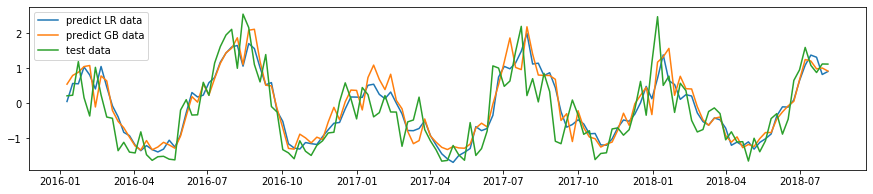

In [51]:
plt.figure(figsize=(15, 3))

plt.xlabel('')
plt.ylabel('')
plt.plot(test.index.get_level_values('Date'), y_test_pred_l, label='predict LR data')
plt.plot(test.index.get_level_values('Date'), y_test_pred_g, label='predict GB data')
plt.plot(test.index.get_level_values('Date'), y_test, label='test data')

plt.legend()
plt.show()

In [52]:
er_l = MAPE(scl_target.inverse_transform(y_test), 
                                      scl_target.inverse_transform(y_test_pred_l))
print(f'MAPE модели линейной регрессии: {er_l}%')

er_g = MAPE(scl_target.inverse_transform(y_test), 
                                      scl_target.inverse_transform(y_test_pred_g))
print(f'MAPE модели градиентного бустинга: {er_g}%')

MAPE модели линейной регрессии: 5.837197583190943%
MAPE модели градиентного бустинга: 6.437643740536887%


Очевидно, на один день вперед мы лучше предсказываем, чем на 4.

#### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 

Теперь используя готовую модель для h=1, мы предскажем рекурсивно для 100 дней вперед.

In [53]:
data_w.columns[list_param]

Index(['PJME_MW', 't52', 't51', 't50', 't49', 't38', 't37', 't36', 't1'], dtype='object')

In [54]:
import re
list_n_hist = list(map(lambda x: int(re.search('\d+', x).group()), data_w.columns[list_param][1:]))
list_n_hist

[52, 51, 50, 49, 38, 37, 36, 1]

In [55]:
def recursive_prediction(start_point, n_points):
    # start_point - от какой точки начинаем предсказывать.
    # n_points - для скольки точек делаем предсказание
    X_test_rec = X_test.copy()
    y_test_rec = y_test.copy()

    for i in range(start_point, n_points):
        y_test_rec[i] = model_l.predict(X_test_rec[i].reshape((1, X_test_rec.shape[1])))
        y_i = scl_target.inverse_transform(y_test_rec[i:i + 1])

        X_test_rec[i, 0] = (y_i - scl_x.mean_[0])/scl_x.scale_[0]

        for n_feature, n_hist in enumerate(list_n_hist):
            if i - n_hist >= 0:  # Пересчитываем только предсказанную историю.
                X_test_rec[i, n_feature + 1] = X_test_rec[i - n_hist, 0]
    return scl_target.inverse_transform(y_test_rec)[0:n_points]

#### Сравним результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек, как того требует задание.

Рекурсивное предсказание

In [56]:
recursive_prediction(0, 4)[-1]

36243.386551793104

Истинное значение

In [57]:
y_true4 = scl_target4.inverse_transform(y_test4)
y_true4[0]

32965.380952380954

Предсказанное прямым методом с горизонтом h=4

In [58]:
y_pred_h4 = scl_target4.inverse_transform(y_test_pred_l)
y_pred_h4[0]

32308.973433856314

Предсказание рекурсивным методом хуже, чем прямым для 4-й точки, но оценивать сам рекурсивный метод по одной точке не стоит

#### 4) Оценим рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, $\dots$ от 90 до 100-й точках.

In [59]:
y_pred_rec = recursive_prediction(0, 100)

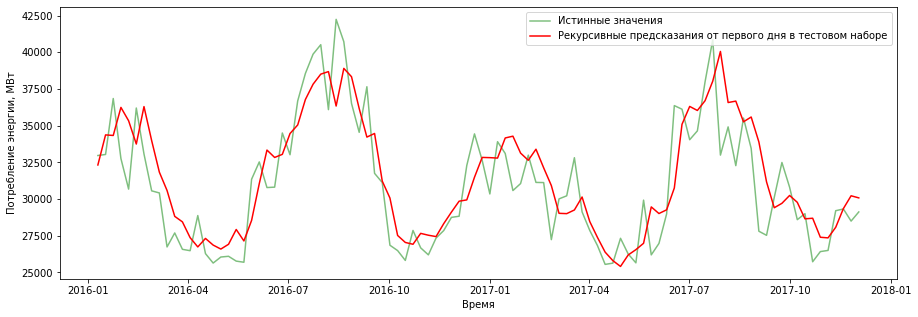

In [65]:
plt.figure(figsize=(15, 5))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')

plt.plot(test.index.get_level_values('Date')[:100], y_true4[:100], 'g', label='Истинные значения', alpha=0.5)
plt.plot(test.index.get_level_values('Date')[:100], y_pred_rec, 'r', label='Рекурсивные предсказания от первого дня в тестовом наборе')

plt.legend()
plt.show()

In [66]:
for i in range(0, 100, 10):
    er_rec = MAPE(scl_target.inverse_transform(y_test[i:i + 10]), y_pred_rec[i:i + 10])
    print(f'MAPE рекурсивной модели на отрезке {i + 1}:{i + 10}: {er_rec}%')

MAPE рекурсивной модели на отрезке 1:10: 8.541314988366018%
MAPE рекурсивной модели на отрезке 11:20: 4.982925638851549%
MAPE рекурсивной модели на отрезке 21:30: 5.610568199043995%
MAPE рекурсивной модели на отрезке 31:40: 6.91316770178764%
MAPE рекурсивной модели на отрезке 41:50: 3.9649145607412506%
MAPE рекурсивной модели на отрезке 51:60: 5.912923662902856%
MAPE рекурсивной модели на отрезке 61:70: 3.707724402207037%
MAPE рекурсивной модели на отрезке 71:80: 6.665328862805363%
MAPE рекурсивной модели на отрезке 81:90: 9.978567878418662%
MAPE рекурсивной модели на отрезке 91:100: 3.8925236508613064%


Модель работает хорошо, уменьшения точности не наблюдается. Скорее всего это из-за того, что у нашего ряда хорошо выраженная сезонность